# Group Details

## Group Number: group visiha

### Student 1: Sidney Damen

### Student 2: Haoqi Guo

### Student 3: Victor Wen

# Loading Data and Preliminaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [2]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [3]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [4]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Data Handling and Preprocessing and helper functions

In [5]:
# Convert array to data object
def array_to_data(task):
    if task == 'task 1':
        train_data_task1 = []
        for i in tqdm(range(700)):
            dataX, dataY = load_array('data/task 1/train/trajectory_' + str(i) + '.npz', task='task 1')
            sourceEdge_array = []
            targetEdge_array = []
            edge_attr_array = []
            for j in range(len(dataX)):
                for k in range(len(dataX)):
                    if j != k:
                        sourceEdge_array.append(j)
                        targetEdge_array.append(k)
                        edge_attr_array.append([dataX[j][1] - dataX[k][1], dataX[j][2] - dataX[k][2]])
                        # m1 = dataX[j][0]
                        # m2 = dataX[k][0]
                        # dx = dataX[j][1] - dataX[k][1]
                        # dy = dataX[j][2] - dataX[k][2]
                        # r = (dx**2 + dy**2)**0.5
                        # f_g = m1 * m2 / r
                        # r_v_x = dataX[j][3] - dataX[k][3]
                        # r_v_y = dataX[j][4] - dataX[k][4]
                        # #dt = 5
                        # edge_attr_array.append([f_g, r, r_v_x, r_v_y, dx, dy])
            edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])
            x = torch.tensor(dataX, dtype=torch.float)
            y = torch.tensor(dataY, dtype=torch.float)
            train_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
            train_data_task1.append(train_data)
        
        validation_data_task1 = []
        for i in tqdm(range(700, 900)):
            dataX, dataY = load_array('data/task 1/train/trajectory_' + str(i) + '.npz', task='task 1')
            sourceEdge_array = []
            targetEdge_array = []
            edge_attr_array = []
            for j in range(len(dataX)):
                for k in range(len(dataX)):
                    if j != k:
                        sourceEdge_array.append(j)
                        targetEdge_array.append(k)
                        edge_attr_array.append([dataX[j][1] - dataX[k][1], dataX[j][2] - dataX[k][2]])
                        # m1 = dataX[j][0]
                        # m2 = dataX[k][0]
                        # dx = dataX[j][1] - dataX[k][1]
                        # dy = dataX[j][2] - dataX[k][2]
                        # r = (dx**2 + dy**2)**0.5
                        # f_g = m1 * m2 / r
                        # r_v_x = dataX[j][3] - dataX[k][3]
                        # r_v_y = dataX[j][4] - dataX[k][4]
                        # #dt = 5
                        # edge_attr_array.append([f_g, r, r_v_x, r_v_y, dx, dy])
            edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])
            x = torch.tensor(dataX, dtype=torch.float)
            y = torch.tensor(dataY, dtype=torch.float)
            valid_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
            validation_data_task1.append(valid_data)

        test_data_task1 = []
        for i in tqdm(range(900, 1000)):
            dataX, dataY = load_array('data/task 1/test/trajectory_' + str(i) + '.npz', task='task 1')
            sourceEdge_array = []
            targetEdge_array = []
            edge_attr_array = []
            for j in range(len(dataX)):
                for k in range(len(dataX)):
                    if j != k:
                        sourceEdge_array.append(j)
                        targetEdge_array.append(k)
                        edge_attr_array.append([dataX[j][1] - dataX[k][1], dataX[j][2] - dataX[k][2]])
                        # m1 = dataX[j][0]
                        # m2 = dataX[k][0]
                        # dx = dataX[j][1] - dataX[k][1]
                        # dy = dataX[j][2] - dataX[k][2]
                        # r = (dx**2 + dy**2)**0.5
                        # f_g = m1 * m2 / r
                        # r_v_x = dataX[j][3] - dataX[k][3]
                        # r_v_y = dataX[j][4] - dataX[k][4]
                        # #dt = 5
                        # edge_attr_array.append([f_g, r, r_v_x, r_v_y, dx, dy])
            edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])    
            x = torch.tensor(dataX, dtype=torch.float)
            y = torch.tensor(dataY, dtype=torch.float)
            test_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
            test_data_task1.append(test_data)

        return train_data_task1, validation_data_task1, test_data_task1

    else:
        train_data_task2 = []
        for i in tqdm(range(700)):
            dataX, dataY = load_array('data/task 2_3/train/trajectory_' + str(i) + '.npz', task='task 2')
            sourceEdge_array = []
            targetEdge_array = []
            edge_attr_array = []
            for j in range(len(dataX)):
                for k in range(len(dataX)):
                    if j != k:
                        sourceEdge_array.append(j)
                        targetEdge_array.append(k)
                        edge_attr_array.append([dataX[j][1] - dataX[k][1], dataX[j][2] - dataX[k][2]])
                        # m1 = dataX[j][0]
                        # m2 = dataX[k][0]
                        # dx = dataX[j][1] - dataX[k][1]
                        # dy = dataX[j][2] - dataX[k][2]
                        # r = (dx**2 + dy**2)**0.5
                        # f_g = m1 * m2 / r
                        # r_v_x = dataX[j][3] - dataX[k][3]
                        # r_v_y = dataX[j][4] - dataX[k][4]
                        # #dt = 5
                        # edge_attr_array.append([f_g, r, r_v_x, r_v_y, dx, dy])
            edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])
            x = torch.tensor(dataX, dtype=torch.float)
            y = torch.tensor(dataY, dtype=torch.float)
            train_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
            train_data_task2.append(train_data)
        
        validation_data_task2 = []
        for i in tqdm(range(700, 900)):
            dataX, dataY = load_array('data/task 2_3/train/trajectory_' + str(i) + '.npz', task='task 2')
            sourceEdge_array = []
            targetEdge_array = []
            edge_attr_array = []
            for j in range(len(dataX)):
                for k in range(len(dataX)):
                    if j != k:
                        sourceEdge_array.append(j)
                        targetEdge_array.append(k)
                        edge_attr_array.append([dataX[j][1] - dataX[k][1], dataX[j][2] - dataX[k][2]])
                        # m1 = dataX[j][0]
                        # m2 = dataX[k][0]
                        # dx = dataX[j][1] - dataX[k][1]
                        # dy = dataX[j][2] - dataX[k][2]
                        # r = (dx**2 + dy**2)**0.5
                        # f_g = m1 * m2 / r
                        # r_v_x = dataX[j][3] - dataX[k][3]
                        # r_v_y = dataX[j][4] - dataX[k][4]
                        # #dt = 5
                        # edge_attr_array.append([f_g, r, r_v_x, r_v_y, dx, dy])
            edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])
            x = torch.tensor(dataX, dtype=torch.float)
            y = torch.tensor(dataY, dtype=torch.float)
            valid_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
            validation_data_task2.append(valid_data)

        test_data_task2 = []
        for i in tqdm(range(900, 1000)):
            dataX, dataY = load_array('data/task 2_3/test/trajectory_' + str(i) + '.npz', task='task 2')
            sourceEdge_array = []
            targetEdge_array = []
            edge_attr_array = []
            for j in range(len(dataX)):
                for k in range(len(dataX)):
                    if j != k:
                        sourceEdge_array.append(j)
                        targetEdge_array.append(k)
                        edge_attr_array.append([dataX[j][1] - dataX[k][1], dataX[j][2] - dataX[k][2]])
                        # m1 = dataX[j][0]
                        # m2 = dataX[k][0]
                        # dx = dataX[j][1] - dataX[k][1]
                        # dy = dataX[j][2] - dataX[k][2]
                        # r = (dx**2 + dy**2)**0.5
                        # f_g = m1 * m2 / r
                        # r_v_x = dataX[j][3] - dataX[k][3]
                        # r_v_y = dataX[j][4] - dataX[k][4]
                        # #dt = 5
                        # edge_attr_array.append([f_g, r, r_v_x, r_v_y, dx, dy])
            edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])    
            x = torch.tensor(dataX, dtype=torch.float)
            y = torch.tensor(dataY, dtype=torch.float)
            test_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
            test_data_task2.append(test_data)

        return train_data_task2, validation_data_task2, test_data_task2

In [6]:
def baselinePerformanceData(task, time=5):
    train_data, validation_data, test_data = array_to_data(task)

    # Create baseline model
    if task == 'task 1':
        all_bodies_terminal_states_train = []
        for trajectory in train_data:
            bodies_terminal_states_train = []
            for body in trajectory.x:
                x, y, vx, vy = body[1], body[2], body[3], body[4]
                terminal_state = x.numpy() + vx.numpy() * time, y.numpy() + vy.numpy() * time
                bodies_terminal_states_train.append(terminal_state)
            all_bodies_terminal_states_train.append(torch.tensor(bodies_terminal_states_train, dtype=torch.float))

        all_bodies_terminal_states_validation = []
        for trajectory in validation_data:
            bodies_terminal_states_validation = []
            for body in trajectory.x:
                x, y, vx, vy = body[1], body[2], body[3], body[4]
                terminal_state = x.numpy() + vx.numpy() * time, y.numpy() + vy.numpy() * time
                bodies_terminal_states_validation.append(terminal_state)
            all_bodies_terminal_states_validation.append(torch.tensor(bodies_terminal_states_validation, dtype=torch.float))

        all_bodies_terminal_states_test = []
        for trajectory in test_data:
            bodies_terminal_states_test = []
            for body in trajectory.x:
                x, y, vx, vy = body[1], body[2], body[3], body[4]
                terminal_state = x.numpy() + vx.numpy() * time, y.numpy() + vy.numpy() * time
                bodies_terminal_states_test.append(terminal_state)
            all_bodies_terminal_states_test.append(torch.tensor(bodies_terminal_states_test, dtype=torch.float))

    else:
        # Compute loss for each time step
        all_bodies_terminal_states_train = []
        for trajectory in train_data:
            bodies_terminal_states_train = []
            for body in trajectory.x:
                bodies_timestep_terminal_states_train = []
                for timestep in range(1, 50):
                    if time == 0:
                        timestep = 0
                    x, y, vx, vy = body[1], body[2], body[3], body[4]
                    terminal_state = x.numpy() + vx.numpy() * timestep, y.numpy() + vy.numpy() * timestep
                    bodies_timestep_terminal_states_train.append(terminal_state)
                bodies_terminal_states_train.append(torch.tensor(bodies_timestep_terminal_states_train, dtype=torch.float))
            all_bodies_terminal_states_train.append(bodies_terminal_states_train)

        all_bodies_terminal_states_validation = []
        for trajectory in validation_data:
            bodies_terminal_states_validation = []
            for body in trajectory.x:
                bodies_timestep_terminal_states_validation = []
                for timestep in range(1, 50):
                    if time == 0:
                        timestep = 0
                    x, y, vx, vy = body[1], body[2], body[3], body[4]
                    terminal_state = x.numpy() + vx.numpy() * timestep, y.numpy() + vy.numpy() * timestep
                    bodies_timestep_terminal_states_validation.append(terminal_state)
                bodies_terminal_states_validation.append(torch.tensor(bodies_timestep_terminal_states_validation, dtype=torch.float))
            all_bodies_terminal_states_validation.append(bodies_terminal_states_validation)

        all_bodies_terminal_states_test = []
        for trajectory in test_data:
            bodies_terminal_states_test = []
            for body in trajectory.x:
                bodies_timestep_terminal_states_test = []
                for timestep in range(1, 50):
                    if time == 0:
                        timestep = 0
                    x, y, vx, vy = body[1], body[2], body[3], body[4]
                    terminal_state = x.numpy() + vx.numpy() * timestep, y.numpy() + vy.numpy() * timestep
                    bodies_timestep_terminal_states_test.append(terminal_state)
                bodies_terminal_states_test.append(torch.tensor(bodies_timestep_terminal_states_test, dtype=torch.float))
            all_bodies_terminal_states_test.append(bodies_terminal_states_test)

    return all_bodies_terminal_states_train, all_bodies_terminal_states_validation, all_bodies_terminal_states_test

In [7]:
def plot_learning_curves(train_losses, val_losses, baseline_losses_t0, baseline_losses_t5):
    # Plot the losses and accuracies
    learning_curves = pd.DataFrame({'Train loss': train_losses, 'Validation loss': val_losses})

    print("Min train loss: {:.4f}".format(learning_curves.iloc[:,0].min()))
    print("Min val loss: {:.4f}".format(learning_curves.iloc[:,1].min()))
    learning_curves.plot(lw=2,style=['b-','r-'])

    # Add horizontal lines for baseline accuracies
    plt.axhline(y=baseline_losses_t0[0], color='b', linestyle=':', label='Baseline train loss T=0')
    plt.axhline(y=baseline_losses_t0[1], color='r', linestyle=':', label='Baseline validation loss T=0')
    if baseline_losses_t5[0] is not None:
        plt.axhline(y=baseline_losses_t5[0], color='b', linestyle='--', label='Baseline train loss T=5')
    if baseline_losses_t5[1] is not None:
        plt.axhline(y=baseline_losses_t5[1], color='r', linestyle='--', label='Baseline validation loss T=5')


    plt.ylabel('loss (MSE)')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

In [8]:
# Load train, validation and test data
train_data_task1, validation_data_task1, test_data_task1 = array_to_data('task 1')

batch_size = 32
train_loader_task1 = DataLoader(train_data_task1, batch_size=batch_size, shuffle=True)
validation_loader_task1 = DataLoader(validation_data_task1, batch_size=batch_size, shuffle=True)
test_loader_task1 = DataLoader(test_data_task1, batch_size=batch_size, shuffle=True)

train_data_task2, validation_data_task2, test_data_task2 = array_to_data('task 2')

batch_size = 32
train_loader_task2 = DataLoader(train_data_task2, batch_size=batch_size, shuffle=True)
validation_loader_task2 = DataLoader(validation_data_task2, batch_size=batch_size, shuffle=True)
test_loader_task2 = DataLoader(test_data_task2, batch_size=batch_size, shuffle=True)

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 118.70it/s]


# Task 1
## Model implementation

In [9]:
class GNNtask1(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, output_dim):
        super(GNNtask1, self).__init__()
        self.node_dim = node_dim

        self.node_to_embedding = torch.nn.Linear(node_dim, hidden_dim)

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2 + edge_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

        self.output_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x, edge_index, edge_attr):
        x = self.node_to_embedding(x)

        edge_message_input = torch.cat([x[edge_index[0,:]], x[edge_index[1,:]], edge_attr], dim=-1)
        edge_message_output = self.edge_mlp(edge_message_input)

        node_agg_messages = torch.zeros(x.size(0), x.size(1))
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_index[1,:].unsqueeze(-1).expand(-1, x.size(1)), src=edge_message_output
        ) 
        
        node_message_input = torch.cat([x, node_agg_messages], dim=-1)
        node_message_output = self.node_mlp(node_message_input)

        output = self.output_mlp(node_message_output)
        return output

# Model Training

In [10]:
# Train model
def train(model, train_loader, val_loader, optimizer, criterion, n_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            y_hat = model(data.x, data.edge_index, data.edge_attr)
            loss = criterion(y_hat, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                y_hat = model(data.x, data.edge_index, data.edge_attr)
                loss = criterion(y_hat, data.y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        
        print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
    return train_losses, val_losses

# Test model
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            y_hat = model(data.x, data.edge_index, data.edge_attr)
            test_loss += criterion(y_hat, data.y)
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss:.4f}')

In [11]:
# Train the model
model = GNNtask1(5, 2, 32, 2)

loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

train_losses, val_losses = train(model, train_loader_task1, validation_loader_task1, optimizer, loss, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:22,  4.33it/s]

Epoch 1/100: Train loss: 21.8427, Val loss: 19.0515
Epoch 2/100: Train loss: 17.8280, Val loss: 13.8637


  4%|▍         | 4/100 [00:00<00:16,  5.73it/s]

Epoch 3/100: Train loss: 10.8273, Val loss: 8.2045
Epoch 4/100: Train loss: 8.9208, Val loss: 7.2392


  6%|▌         | 6/100 [00:01<00:15,  6.24it/s]

Epoch 5/100: Train loss: 8.0636, Val loss: 6.5744
Epoch 6/100: Train loss: 7.7887, Val loss: 6.5703


  8%|▊         | 8/100 [00:01<00:14,  6.30it/s]

Epoch 7/100: Train loss: 7.4834, Val loss: 6.2113
Epoch 8/100: Train loss: 7.3659, Val loss: 5.8731


 10%|█         | 10/100 [00:01<00:13,  6.68it/s]

Epoch 9/100: Train loss: 6.9836, Val loss: 5.7611
Epoch 10/100: Train loss: 6.7994, Val loss: 5.8283


 12%|█▏        | 12/100 [00:01<00:12,  7.15it/s]

Epoch 11/100: Train loss: 6.6486, Val loss: 5.6949
Epoch 12/100: Train loss: 6.6640, Val loss: 5.3719


 14%|█▍        | 14/100 [00:02<00:11,  7.30it/s]

Epoch 13/100: Train loss: 6.2340, Val loss: 5.4107
Epoch 14/100: Train loss: 6.0377, Val loss: 5.4458


 16%|█▌        | 16/100 [00:02<00:11,  7.05it/s]

Epoch 15/100: Train loss: 5.8696, Val loss: 5.1086
Epoch 16/100: Train loss: 5.7629, Val loss: 5.2347


 18%|█▊        | 18/100 [00:02<00:11,  7.25it/s]

Epoch 17/100: Train loss: 5.6617, Val loss: 5.0856
Epoch 18/100: Train loss: 5.5147, Val loss: 4.8517


 20%|██        | 20/100 [00:03<00:10,  7.34it/s]

Epoch 19/100: Train loss: 5.3412, Val loss: 4.8972
Epoch 20/100: Train loss: 5.3332, Val loss: 5.0934


 22%|██▏       | 22/100 [00:03<00:10,  7.37it/s]

Epoch 21/100: Train loss: 5.1870, Val loss: 4.6307
Epoch 22/100: Train loss: 5.1097, Val loss: 4.4965


 24%|██▍       | 24/100 [00:03<00:10,  7.49it/s]

Epoch 23/100: Train loss: 5.1050, Val loss: 5.0596
Epoch 24/100: Train loss: 5.0946, Val loss: 4.5221


 26%|██▌       | 26/100 [00:03<00:09,  7.49it/s]

Epoch 25/100: Train loss: 5.0325, Val loss: 4.8113
Epoch 26/100: Train loss: 4.9094, Val loss: 4.4211


 28%|██▊       | 28/100 [00:04<00:09,  7.41it/s]

Epoch 27/100: Train loss: 5.1378, Val loss: 4.7475
Epoch 28/100: Train loss: 4.7395, Val loss: 4.6264


 30%|███       | 30/100 [00:04<00:09,  7.16it/s]

Epoch 29/100: Train loss: 4.7478, Val loss: 4.7494
Epoch 30/100: Train loss: 4.7457, Val loss: 4.3832


 32%|███▏      | 32/100 [00:04<00:09,  7.40it/s]

Epoch 31/100: Train loss: 4.6759, Val loss: 4.4461
Epoch 32/100: Train loss: 4.7427, Val loss: 4.4488


 34%|███▍      | 34/100 [00:04<00:08,  7.41it/s]

Epoch 33/100: Train loss: 4.6754, Val loss: 4.5993
Epoch 34/100: Train loss: 4.7658, Val loss: 4.4178


 36%|███▌      | 36/100 [00:05<00:08,  7.63it/s]

Epoch 35/100: Train loss: 4.7758, Val loss: 4.4013
Epoch 36/100: Train loss: 4.8780, Val loss: 4.6295


 38%|███▊      | 38/100 [00:05<00:08,  7.62it/s]

Epoch 37/100: Train loss: 4.5838, Val loss: 4.2579
Epoch 38/100: Train loss: 4.5028, Val loss: 4.3066


 40%|████      | 40/100 [00:05<00:07,  7.69it/s]

Epoch 39/100: Train loss: 4.4962, Val loss: 4.2307
Epoch 40/100: Train loss: 4.4902, Val loss: 4.8275


 42%|████▏     | 42/100 [00:05<00:07,  7.54it/s]

Epoch 41/100: Train loss: 4.4554, Val loss: 4.3354
Epoch 42/100: Train loss: 4.4841, Val loss: 4.4655


 44%|████▍     | 44/100 [00:06<00:07,  7.48it/s]

Epoch 43/100: Train loss: 4.4807, Val loss: 4.1358
Epoch 44/100: Train loss: 4.4395, Val loss: 4.1623


 46%|████▌     | 46/100 [00:06<00:07,  7.40it/s]

Epoch 45/100: Train loss: 4.3818, Val loss: 4.2938
Epoch 46/100: Train loss: 4.3551, Val loss: 4.0453


 48%|████▊     | 48/100 [00:06<00:07,  7.03it/s]

Epoch 47/100: Train loss: 4.3464, Val loss: 4.1490
Epoch 48/100: Train loss: 4.2809, Val loss: 4.5191


 50%|█████     | 50/100 [00:07<00:07,  6.84it/s]

Epoch 49/100: Train loss: 4.3171, Val loss: 4.0267
Epoch 50/100: Train loss: 4.3519, Val loss: 3.9362


 52%|█████▏    | 52/100 [00:07<00:07,  6.04it/s]

Epoch 51/100: Train loss: 4.2512, Val loss: 3.8764
Epoch 52/100: Train loss: 4.2967, Val loss: 4.1815


 54%|█████▍    | 54/100 [00:07<00:07,  6.52it/s]

Epoch 53/100: Train loss: 4.2177, Val loss: 4.3564
Epoch 54/100: Train loss: 4.2124, Val loss: 4.2465


 56%|█████▌    | 56/100 [00:08<00:06,  6.81it/s]

Epoch 55/100: Train loss: 4.1425, Val loss: 4.1654
Epoch 56/100: Train loss: 4.1878, Val loss: 4.0729


 58%|█████▊    | 58/100 [00:08<00:06,  6.97it/s]

Epoch 57/100: Train loss: 4.2331, Val loss: 4.1772
Epoch 58/100: Train loss: 4.1543, Val loss: 3.9763


 60%|██████    | 60/100 [00:08<00:05,  7.36it/s]

Epoch 59/100: Train loss: 4.2701, Val loss: 4.1105
Epoch 60/100: Train loss: 4.5223, Val loss: 4.1244


 62%|██████▏   | 62/100 [00:08<00:05,  7.52it/s]

Epoch 61/100: Train loss: 4.3785, Val loss: 3.9494
Epoch 62/100: Train loss: 4.2218, Val loss: 4.0591


 64%|██████▍   | 64/100 [00:09<00:04,  7.30it/s]

Epoch 63/100: Train loss: 4.1854, Val loss: 4.2811
Epoch 64/100: Train loss: 4.0913, Val loss: 4.1022


 66%|██████▌   | 66/100 [00:09<00:05,  6.75it/s]

Epoch 65/100: Train loss: 4.1097, Val loss: 4.0974
Epoch 66/100: Train loss: 4.2598, Val loss: 3.8571


 68%|██████▊   | 68/100 [00:09<00:04,  6.92it/s]

Epoch 67/100: Train loss: 4.1261, Val loss: 4.1313
Epoch 68/100: Train loss: 4.4228, Val loss: 4.4973


 70%|███████   | 70/100 [00:10<00:04,  6.98it/s]

Epoch 69/100: Train loss: 4.8515, Val loss: 4.0535
Epoch 70/100: Train loss: 4.5929, Val loss: 4.1497


 72%|███████▏  | 72/100 [00:10<00:03,  7.22it/s]

Epoch 71/100: Train loss: 4.1911, Val loss: 3.9581
Epoch 72/100: Train loss: 4.0584, Val loss: 4.0280


 74%|███████▍  | 74/100 [00:10<00:03,  7.36it/s]

Epoch 73/100: Train loss: 4.1027, Val loss: 4.3217
Epoch 74/100: Train loss: 4.0248, Val loss: 4.3721


 76%|███████▌  | 76/100 [00:10<00:03,  6.74it/s]

Epoch 75/100: Train loss: 4.0162, Val loss: 4.0348
Epoch 76/100: Train loss: 3.9862, Val loss: 3.8735


 78%|███████▊  | 78/100 [00:11<00:03,  6.83it/s]

Epoch 77/100: Train loss: 3.9508, Val loss: 4.1403
Epoch 78/100: Train loss: 3.9230, Val loss: 4.4586


 80%|████████  | 80/100 [00:11<00:02,  6.89it/s]

Epoch 79/100: Train loss: 3.9236, Val loss: 3.8187
Epoch 80/100: Train loss: 3.8949, Val loss: 3.6953


 82%|████████▏ | 82/100 [00:11<00:02,  6.59it/s]

Epoch 81/100: Train loss: 3.9980, Val loss: 3.8040
Epoch 82/100: Train loss: 4.2407, Val loss: 4.1907


 84%|████████▍ | 84/100 [00:12<00:02,  6.54it/s]

Epoch 83/100: Train loss: 4.2768, Val loss: 3.8240
Epoch 84/100: Train loss: 4.1502, Val loss: 4.4112


 86%|████████▌ | 86/100 [00:12<00:01,  7.15it/s]

Epoch 85/100: Train loss: 3.9019, Val loss: 3.9089
Epoch 86/100: Train loss: 3.8929, Val loss: 3.8846


 88%|████████▊ | 88/100 [00:12<00:01,  7.41it/s]

Epoch 87/100: Train loss: 3.8385, Val loss: 3.9147
Epoch 88/100: Train loss: 3.9442, Val loss: 3.8197


 90%|█████████ | 90/100 [00:12<00:01,  7.32it/s]

Epoch 89/100: Train loss: 3.8583, Val loss: 3.8982
Epoch 90/100: Train loss: 4.0139, Val loss: 4.2248


 92%|█████████▏| 92/100 [00:13<00:01,  7.08it/s]

Epoch 91/100: Train loss: 3.9076, Val loss: 3.8799
Epoch 92/100: Train loss: 3.8681, Val loss: 4.2291


 94%|█████████▍| 94/100 [00:13<00:00,  7.43it/s]

Epoch 93/100: Train loss: 3.8287, Val loss: 3.8218
Epoch 94/100: Train loss: 3.7628, Val loss: 4.0067


 96%|█████████▌| 96/100 [00:13<00:00,  7.14it/s]

Epoch 95/100: Train loss: 3.8172, Val loss: 3.9700
Epoch 96/100: Train loss: 3.8515, Val loss: 3.8031


 98%|█████████▊| 98/100 [00:14<00:00,  6.91it/s]

Epoch 97/100: Train loss: 3.8763, Val loss: 4.3673
Epoch 98/100: Train loss: 3.9101, Val loss: 4.1804


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]

Epoch 99/100: Train loss: 3.8293, Val loss: 3.7537
Epoch 100/100: Train loss: 3.8104, Val loss: 4.2474


# Evaluation

In [12]:
test(model, test_loader_task1, loss)

Test loss: 2.5890


In [27]:
# Get the linear baseline performance data at time 5
train_baseline_t5_task1, validation_baseline_t5_task1, test_baseline_t5_task1 = baselinePerformanceData('task 1', time=5)

# Get the constant baseline performance data at time 0
train_baseline_t0_task1, validation_baseline_t0_task1, test_baseline_t0_task1 = baselinePerformanceData('task 1', time=0)

# Get the output of train, validation and test data for task 1
true_output_task1_train = [train_data_task1[i].y for i in range(len(train_data_task1))]
true_output_task1_validation = [validation_data_task1[i].y for i in range(len(validation_data_task1))]
true_output_task1_test = [test_data_task1[i].y for i in range(len(test_data_task1))]

loss_values_train_t5_task1 = []
loss_values_validation_t5_task1 = []
loss_values_test_t5_task1 = []
for trajectoryIndex in range(len(train_baseline_t5_task1)):
    loss_values_train_t5_task1.append(loss(train_baseline_t5_task1[trajectoryIndex], true_output_task1_train[trajectoryIndex]))
for trajectoryIndex in range(len(validation_baseline_t5_task1)):
    loss_values_validation_t5_task1.append(loss(validation_baseline_t5_task1[trajectoryIndex], true_output_task1_validation[trajectoryIndex]))
for trajectoryIndex in range(len(test_baseline_t5_task1)):
    loss_values_test_t5_task1.append(loss(test_baseline_t5_task1[trajectoryIndex], true_output_task1_test[trajectoryIndex]))

loss_values_test_t0_task1 = []
loss_values_validation_t0_task1 = []
loss_values_train_t0_task1 = []
for trajectoryIndex in range(len(train_baseline_t0_task1)):
    loss_values_train_t0_task1.append(loss(train_baseline_t0_task1[trajectoryIndex], true_output_task1_train[trajectoryIndex]))
for trajectoryIndex in range(len(validation_baseline_t0_task1)):
    loss_values_validation_t0_task1.append(loss(validation_baseline_t0_task1[trajectoryIndex], true_output_task1_validation[trajectoryIndex]))
for trajectoryIndex in range(len(test_baseline_t0_task1)):
    loss_values_test_t0_task1.append(loss(test_baseline_t0_task1[trajectoryIndex], true_output_task1_test[trajectoryIndex]))

average_baseline_train_t5_task1 = sum(loss_values_train_t5_task1)/len(loss_values_train_t5_task1)
average_baseline_validation_t5_task1 = sum(loss_values_validation_t5_task1)/len(loss_values_validation_t5_task1)
average_baseline_test_t5_task1 = sum(loss_values_test_t5_task1)/len(loss_values_test_t5_task1)

average_baseline_train_t0_task1 = sum(loss_values_train_t0_task1)/len(loss_values_train_t0_task1)
average_baseline_validation_t0_task1 = sum(loss_values_validation_t0_task1)/len(loss_values_validation_t0_task1)
average_baseline_test_t0_task1 = sum(loss_values_test_t0_task1)/len(loss_values_test_t0_task1)

print()
print('Linear baseline train loss T=5: ', average_baseline_train_t5_task1)
print('Linear baseline validation loss T=5: ', average_baseline_validation_t5_task1)
print('Linear baseline test loss T=5: ', average_baseline_test_t5_task1)
print()
print('Constant baseline train loss T=0: ', average_baseline_train_t0_task1)
print('Constant baseline validation loss T=0: ', average_baseline_validation_t0_task1)
print('Constant baseline test loss T=0: ', average_baseline_test_t0_task1)

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 855.42it/s]



Linear baseline train loss T=5:  tensor(19.8818)
Linear baseline validation loss T=5:  tensor(21.3868)
Linear baseline test loss T=5:  tensor(19.2341)

Constant baseline train loss T=0:  tensor(13.0581)
Constant baseline validation loss T=0:  tensor(12.5684)
Constant baseline test loss T=0:  tensor(10.7660)


Min train loss: 3.7628
Min val loss: 3.6953


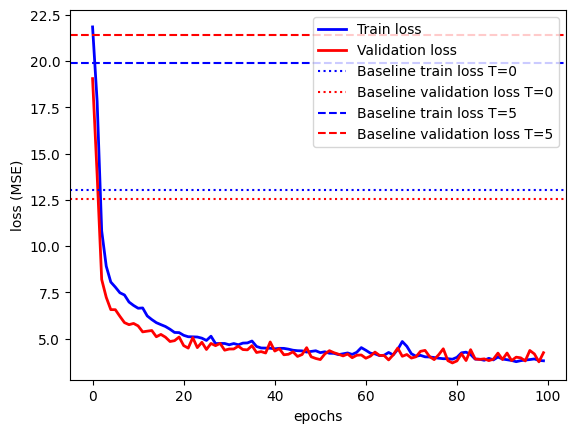

In [14]:
plot_learning_curves(train_losses, val_losses, [average_baseline_train_t0_task1, average_baseline_validation_t0_task1, average_baseline_test_t0_task1], 
                     [average_baseline_train_t5_task1, average_baseline_validation_t5_task1, average_baseline_test_t5_task1])

# Task 2

In [15]:
# Train model
def train2(model, train_loader, val_loader, optimizer, criterion, n_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            y_hat = model(data.x, data.edge_index, data.edge_attr)
            loss = criterion(y_hat[:, :, :2], data.y[:, :, :2])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                y_hat = model(data.x, data.edge_index, data.edge_attr)
                loss = criterion(y_hat[:, :, :2], data.y[:, :, :2])
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        
        print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
    return train_losses, val_losses

# Test model
def test2(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            y_hat = model(data.x, data.edge_index, data.edge_attr)
            test_loss += criterion(y_hat[:, :, :2], data.y[:, :, :2])
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss:.4f}')

In [16]:
class GNNtask2(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, output_dim):
        super(GNNtask2, self).__init__()
        self.node_dim = node_dim

        self.node_to_embedding = torch.nn.Linear(node_dim, hidden_dim)
        self.node_to_embedding2 = torch.nn.Linear(4, hidden_dim)

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2 + edge_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

        self.output_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        output_list = []

        x = self.node_to_embedding(x)

        edge_message_input = torch.cat([x[edge_index[0,:]], x[edge_index[1,:]], edge_attr], dim=-1)
        edge_message_output = self.edge_mlp(edge_message_input)

        node_agg_messages = torch.zeros(x.size(0), x.size(1))
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_index[1,:].unsqueeze(-1).expand(-1, x.size(1)), src=edge_message_output
        )
        
        node_message_input = torch.cat([x, node_agg_messages], dim=-1)
        node_message_output = self.node_mlp(node_message_input)

        output = self.output_mlp(node_message_output)
        output_list.append(output)

        for _ in range(48):
            x = self.node_to_embedding2(output_list[-1])

            edge_message_input = torch.cat([x[edge_index[0,:]], x[edge_index[1,:]], edge_attr], dim=-1)
            edge_message_output = self.edge_mlp(edge_message_input)

            node_agg_messages = torch.zeros(x.size(0), x.size(1))
            node_agg_messages = node_agg_messages.scatter_add_(
                dim=0, index=edge_index[1,:].unsqueeze(-1).expand(-1, x.size(1)), src=edge_message_output
            )
            
            node_message_input = torch.cat([x, node_agg_messages], dim=-1)
            node_message_output = self.node_mlp(node_message_input)

            output = self.output_mlp(node_message_output)
            output_list.append(output)
        
        # Reshape output to (num_nodes, num_timesteps, output_dim)
        reshapedOutput = torch.zeros(output_list[0].size(0), len(output_list), output_list[0].size(1))
        for i in range(len(output_list)):
            reshapedOutput[:,i,:] = output_list[i]
        return reshapedOutput

In [30]:
# Train the model
model = GNNtask2(5, 2, 32, 4)

loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

train_losses2, val_losses2 = train2(model, train_loader_task2, validation_loader_task2, optimizer, loss, n_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:03<02:47,  3.41s/it]

Epoch 1/50: Train loss: 20.9518, Val loss: 20.1415


  4%|▍         | 2/50 [00:06<02:38,  3.30s/it]

Epoch 2/50: Train loss: 20.0426, Val loss: 17.6962


  6%|▌         | 3/50 [00:09<02:30,  3.20s/it]

Epoch 3/50: Train loss: 15.6004, Val loss: 13.3567


  8%|▊         | 4/50 [00:12<02:28,  3.22s/it]

Epoch 4/50: Train loss: 13.4951, Val loss: 11.3288


 10%|█         | 5/50 [00:16<02:29,  3.33s/it]

Epoch 5/50: Train loss: 11.4731, Val loss: 9.5141


 12%|█▏        | 6/50 [00:19<02:22,  3.24s/it]

Epoch 6/50: Train loss: 10.4742, Val loss: 8.5791


 14%|█▍        | 7/50 [00:22<02:17,  3.21s/it]

Epoch 7/50: Train loss: 9.2256, Val loss: 7.8831


 16%|█▌        | 8/50 [00:26<02:16,  3.24s/it]

Epoch 8/50: Train loss: 8.3791, Val loss: 6.9703


 18%|█▊        | 9/50 [00:29<02:14,  3.29s/it]

Epoch 9/50: Train loss: 7.7912, Val loss: 6.6232


 20%|██        | 10/50 [00:32<02:12,  3.32s/it]

Epoch 10/50: Train loss: 7.5407, Val loss: 6.4863


 22%|██▏       | 11/50 [00:36<02:14,  3.45s/it]

Epoch 11/50: Train loss: 7.2863, Val loss: 6.1866


 24%|██▍       | 12/50 [00:40<02:12,  3.48s/it]

Epoch 12/50: Train loss: 7.4947, Val loss: 6.5752


 26%|██▌       | 13/50 [00:43<02:03,  3.35s/it]

Epoch 13/50: Train loss: 7.2462, Val loss: 6.4217


 28%|██▊       | 14/50 [00:46<01:56,  3.23s/it]

Epoch 14/50: Train loss: 7.4043, Val loss: 6.8755


 30%|███       | 15/50 [00:49<01:50,  3.17s/it]

Epoch 15/50: Train loss: 7.4927, Val loss: 6.4464


 32%|███▏      | 16/50 [00:52<01:47,  3.15s/it]

Epoch 16/50: Train loss: 7.0529, Val loss: 6.1226


 34%|███▍      | 17/50 [00:55<01:43,  3.14s/it]

Epoch 17/50: Train loss: 6.6976, Val loss: 5.9170


 36%|███▌      | 18/50 [00:58<01:39,  3.11s/it]

Epoch 18/50: Train loss: 6.5336, Val loss: 5.4898


 38%|███▊      | 19/50 [01:01<01:35,  3.09s/it]

Epoch 19/50: Train loss: 6.9568, Val loss: 5.9785


 40%|████      | 20/50 [01:04<01:32,  3.07s/it]

Epoch 20/50: Train loss: 6.9536, Val loss: 6.2494


 42%|████▏     | 21/50 [01:07<01:28,  3.06s/it]

Epoch 21/50: Train loss: 6.6967, Val loss: 6.1055


 44%|████▍     | 22/50 [01:10<01:25,  3.06s/it]

Epoch 22/50: Train loss: 6.6355, Val loss: 5.6388


 46%|████▌     | 23/50 [01:13<01:22,  3.06s/it]

Epoch 23/50: Train loss: 6.4320, Val loss: 5.3913


 48%|████▊     | 24/50 [01:16<01:19,  3.05s/it]

Epoch 24/50: Train loss: 6.8036, Val loss: 8.2442


 50%|█████     | 25/50 [01:19<01:16,  3.04s/it]

Epoch 25/50: Train loss: 7.8864, Val loss: 7.0330


 52%|█████▏    | 26/50 [01:22<01:12,  3.04s/it]

Epoch 26/50: Train loss: 7.3403, Val loss: 6.3186


 54%|█████▍    | 27/50 [01:25<01:09,  3.03s/it]

Epoch 27/50: Train loss: 7.0853, Val loss: 6.2671


 56%|█████▌    | 28/50 [01:28<01:06,  3.04s/it]

Epoch 28/50: Train loss: 6.6377, Val loss: 5.6930


 58%|█████▊    | 29/50 [01:31<01:03,  3.02s/it]

Epoch 29/50: Train loss: 6.3451, Val loss: 5.3229


 60%|██████    | 30/50 [01:34<01:00,  3.01s/it]

Epoch 30/50: Train loss: 6.0960, Val loss: 5.6353


 62%|██████▏   | 31/50 [01:37<00:57,  3.01s/it]

Epoch 31/50: Train loss: 5.9605, Val loss: 5.0308


 64%|██████▍   | 32/50 [01:40<00:54,  3.01s/it]

Epoch 32/50: Train loss: 6.0808, Val loss: 5.1527


 66%|██████▌   | 33/50 [01:43<00:50,  2.98s/it]

Epoch 33/50: Train loss: 5.7771, Val loss: 5.1208


 68%|██████▊   | 34/50 [01:46<00:47,  2.99s/it]

Epoch 34/50: Train loss: 5.9872, Val loss: 5.0241


 70%|███████   | 35/50 [01:49<00:44,  2.96s/it]

Epoch 35/50: Train loss: 5.9037, Val loss: 5.0945


 72%|███████▏  | 36/50 [01:52<00:41,  2.96s/it]

Epoch 36/50: Train loss: 5.8673, Val loss: 4.9649


 74%|███████▍  | 37/50 [01:55<00:38,  2.98s/it]

Epoch 37/50: Train loss: 5.9714, Val loss: 5.1374


 76%|███████▌  | 38/50 [01:58<00:35,  2.98s/it]

Epoch 38/50: Train loss: 5.7482, Val loss: 4.5303


 78%|███████▊  | 39/50 [02:01<00:33,  3.01s/it]

Epoch 39/50: Train loss: 5.5777, Val loss: 4.7519


 80%|████████  | 40/50 [02:04<00:30,  3.02s/it]

Epoch 40/50: Train loss: 5.9482, Val loss: 5.6082


 82%|████████▏ | 41/50 [02:07<00:27,  3.06s/it]

Epoch 41/50: Train loss: 5.7517, Val loss: 4.8823


 84%|████████▍ | 42/50 [02:10<00:24,  3.04s/it]

Epoch 42/50: Train loss: 5.8808, Val loss: 5.8565


 86%|████████▌ | 43/50 [02:13<00:21,  3.04s/it]

Epoch 43/50: Train loss: 5.8211, Val loss: 4.7548


 88%|████████▊ | 44/50 [02:16<00:18,  3.03s/it]

Epoch 44/50: Train loss: 5.7361, Val loss: 4.9871


 90%|█████████ | 45/50 [02:19<00:15,  3.05s/it]

Epoch 45/50: Train loss: 5.5909, Val loss: 4.7055


 92%|█████████▏| 46/50 [02:23<00:12,  3.06s/it]

Epoch 46/50: Train loss: 5.4124, Val loss: 4.4736


 94%|█████████▍| 47/50 [02:26<00:09,  3.04s/it]

Epoch 47/50: Train loss: 5.3624, Val loss: 4.3852


 96%|█████████▌| 48/50 [02:28<00:06,  3.01s/it]

Epoch 48/50: Train loss: 5.3579, Val loss: 4.7832


 98%|█████████▊| 49/50 [02:31<00:02,  2.99s/it]

Epoch 49/50: Train loss: 5.4204, Val loss: 4.5501


100%|██████████| 50/50 [02:34<00:00,  3.10s/it]

Epoch 50/50: Train loss: 5.4724, Val loss: 4.6316


In [31]:
test2(model, test_loader_task2, loss)

Test loss: 4.1372


In [32]:
# Get the linear baseline performance data at time 5
train_baseline_t5_task2, validation_baseline_t5_task2, test_baseline_t5_task2 = baselinePerformanceData('task 2', time=5)

# Get the constant baseline performance data at time 0
train_baseline_t0_task2, validation_baseline_t0_task2, test_baseline_t0_task2 = baselinePerformanceData('task 2', time=0)

# Get the output of train, validation and test data for task 2
true_output_task2_train = [train_data_task2[i].y[:, :, :2] for i in range(len(train_data_task2))]
true_output_task2_validation = [validation_data_task2[i].y[:, :, :2] for i in range(len(validation_data_task2))]
true_output_task2_test = [test_data_task2[i].y[:, :, :2] for i in range(len(test_data_task2))]

loss_values_train_t5_task2 = []
loss_values_validation_t5_task2 = []
loss_values_test_t5_task2 = []
for trajectoryIndex in range(len(train_baseline_t5_task2)):
    for bodyIndex in range(len(train_baseline_t5_task2[trajectoryIndex])):
        loss_values_train_t5_task2.append(loss(train_baseline_t5_task2[trajectoryIndex][bodyIndex], true_output_task2_train[trajectoryIndex][bodyIndex]))
for trajectoryIndex in range(len(validation_baseline_t5_task2)):
    for bodyIndex in range(len(validation_baseline_t5_task2[trajectoryIndex])):
        loss_values_validation_t5_task2.append(loss(validation_baseline_t5_task2[trajectoryIndex][bodyIndex], true_output_task2_validation[trajectoryIndex][bodyIndex]))
for trajectoryIndex in range(len(test_baseline_t5_task2)):
    for bodyIndex in range(len(test_baseline_t5_task2[trajectoryIndex])):
        loss_values_test_t5_task2.append(loss(test_baseline_t5_task2[trajectoryIndex][bodyIndex], true_output_task2_test[trajectoryIndex][bodyIndex]))

loss_values_train_t0_task2  = []
loss_values_validation_t0_task2  = []
loss_values_test_t0_task2  = []
for trajectoryIndex in range(len(train_baseline_t0_task2)):
    for bodyIndex in range(len(train_baseline_t0_task2[trajectoryIndex])):
        loss_values_train_t0_task2.append(loss(train_baseline_t0_task2[trajectoryIndex][bodyIndex], true_output_task2_train[trajectoryIndex][bodyIndex]))
for trajectoryIndex in range(len(validation_baseline_t0_task2)):
    for bodyIndex in range(len(validation_baseline_t0_task2[trajectoryIndex])):
        loss_values_validation_t0_task2.append(loss(validation_baseline_t0_task2[trajectoryIndex][bodyIndex], true_output_task2_validation[trajectoryIndex][bodyIndex]))
for trajectoryIndex in range(len(test_baseline_t0_task2)):
    for bodyIndex in range(len(test_baseline_t0_task2[trajectoryIndex])):
        loss_values_test_t0_task2.append(loss(test_baseline_t0_task2[trajectoryIndex][bodyIndex], true_output_task2_test[trajectoryIndex][bodyIndex]))

average_baseline_train_t5_task2 = sum(loss_values_train_t5_task2)/len(loss_values_train_t5_task2)
average_baseline_validation_t5_task2 = sum(loss_values_validation_t5_task2)/len(loss_values_validation_t5_task2)
average_baseline_test_t5_task2 = sum(loss_values_test_t5_task2)/len(loss_values_test_t5_task2)

average_baseline_train_t0_task2 = sum(loss_values_train_t0_task2)/len(loss_values_train_t0_task2)
average_baseline_validation_t0_task2 = sum(loss_values_validation_t0_task2)/len(loss_values_validation_t0_task2)
average_baseline_test_t0_task2 = sum(loss_values_test_t0_task2)/len(loss_values_test_t0_task2)

print()
print('Linear baseline train loss T=5: ', average_baseline_train_t5_task2)
print('Linear baseline validation loss T=5: ', average_baseline_validation_t5_task2)
print('Linear baseline test loss T=5: ', average_baseline_test_t5_task2)
print()
print('Constant baseline train loss T=0: ', average_baseline_train_t0_task2)
print('Constant baseline validation loss T=0: ', average_baseline_validation_t0_task2)
print('Constant baseline test loss T=0: ', average_baseline_test_t0_task2)

100%|██████████| 100/100 [00:00<00:00, 979.84it/s]



Linear baseline train loss T=5:  tensor(799.3806)
Linear baseline validation loss T=5:  tensor(852.0614)
Linear baseline test loss T=5:  tensor(877.2458)

Constant baseline train loss T=0:  tensor(5.1606)
Constant baseline validation loss T=0:  tensor(4.8228)
Constant baseline test loss T=0:  tensor(5.1931)


Min train loss: 5.3579
Min val loss: 4.3852


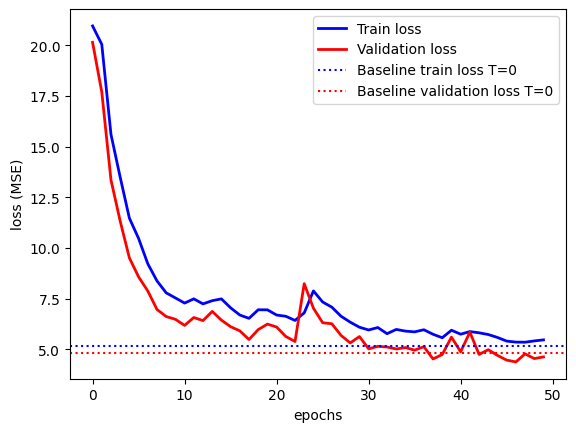

In [33]:
plot_learning_curves(train_losses2, val_losses2, [average_baseline_train_t0_task2, average_baseline_validation_t0_task2, average_baseline_test_t0_task2],
                     [None, None, None])

# Task 3

In [176]:
def generate_data(data):    
    new_data = []
    dataX, dataY = load_array('data/task 2_3/train/trajectory_' + str(data) + '.npz', task='task 2')
    noise = np.random.normal(0, 1, size=dataX.shape)
    new_dataX = dataX + noise
    sourceEdge_array = []
    targetEdge_array = []
    edge_attr_array = []
    for j in range(len(dataX)):
        for k in range(len(dataX)):
            if j != k:
                sourceEdge_array.append(j)
                targetEdge_array.append(k)
                edge_attr_array.append([new_dataX[j][1] - new_dataX[k][1], new_dataX[j][2] - new_dataX[k][2]])
    edge_array = torch.stack([torch.tensor(sourceEdge_array), torch.tensor(targetEdge_array)])
    x = torch.tensor(new_dataX, dtype=torch.float)
    y = torch.tensor(dataY, dtype=torch.float)
    new_data = Data(x=x, edge_index=edge_array, y=y, edge_attr=torch.tensor(edge_attr_array, dtype=torch.float))
    return new_data

In [177]:
n = 25
n_samples = 100
final_predictions = [] 
_ , data_y = load_array('data/task 2_3/train/trajectory_' + str(1) + '.npz', task='task 2')

for i in tqdm(range(n)):
    predicted_trajectories = []
    for i in range(n_samples):
        new_data = generate_data(1)
        y_hat = model(new_data.x, new_data.edge_index, new_data.edge_attr)
        predicted_trajectories.append(y_hat[:, :, :2])
    new_predicted_trajectories = torch.stack(predicted_trajectories)
    mean_predicted_trajectories = torch.mean(new_predicted_trajectories, 0)
    final_predictions.append(mean_predicted_trajectories)


100%|██████████| 25/25 [02:26<00:00,  5.87s/it]


In [178]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

final = torch.stack(final_predictions)

true_predictions = data_y[:, :, :2]

C:\Users\victo\AppData\Local\Temp\ipykernel_26092\1616491225.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(true_x, true_y, 'b--', color=colors[body_idx], label='True trajectory of body '+str(body_idx+1))


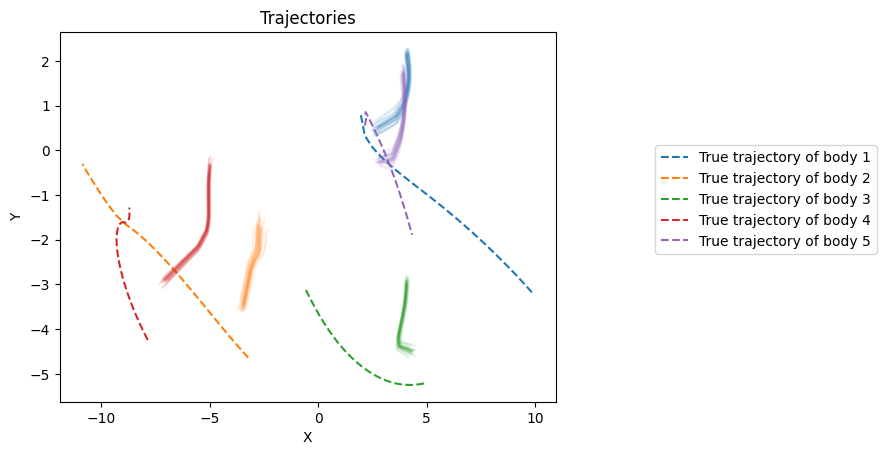

In [179]:
for body_idx in range(len(true_predictions)):
    true_x = true_predictions[body_idx][:,0]
    true_y = true_predictions[body_idx][:,1]
    plt.plot(true_x, true_y, 'b--', color=colors[body_idx], label='True trajectory of body '+str(body_idx+1))
    for i in range(len(final)):
        pred_x = final[i][body_idx][:,0].detach().numpy()
        #print(pred_x)
        pred_y = final[i][body_idx][:,1].detach().numpy()
        plt.plot(pred_x, pred_y, color=colors[body_idx], alpha=0.1)

    plt.title("Trajectories")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc=(1.2 , 0.4))

In [180]:
n = 25
n_samples = 100
final_predictions = [] 
_ , data_y = load_array('data/task 2_3/train/trajectory_' + str(2) + '.npz', task='task 2')

for i in tqdm(range(n)):
    predicted_trajectories = []
    for i in range(n_samples):
        new_data = generate_data(2)
        y_hat = model(new_data.x, new_data.edge_index, new_data.edge_attr)
        predicted_trajectories.append(y_hat[:, :, :2])
    new_predicted_trajectories = torch.stack(predicted_trajectories)
    mean_predicted_trajectories = torch.mean(new_predicted_trajectories, 0)
    final_predictions.append(mean_predicted_trajectories)

100%|██████████| 25/25 [03:26<00:00,  8.25s/it]


In [181]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

final = torch.stack(final_predictions)

true_predictions = data_y[:, :, :2]


C:\Users\victo\AppData\Local\Temp\ipykernel_26092\1315941032.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(true_x, true_y, 'b--', color=colors[body_idx], label='True trajectory of body '+str(body_idx+1))


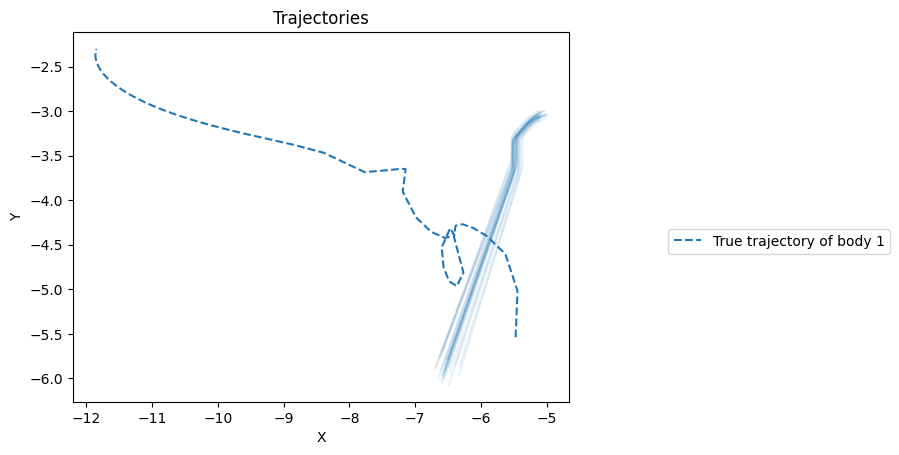

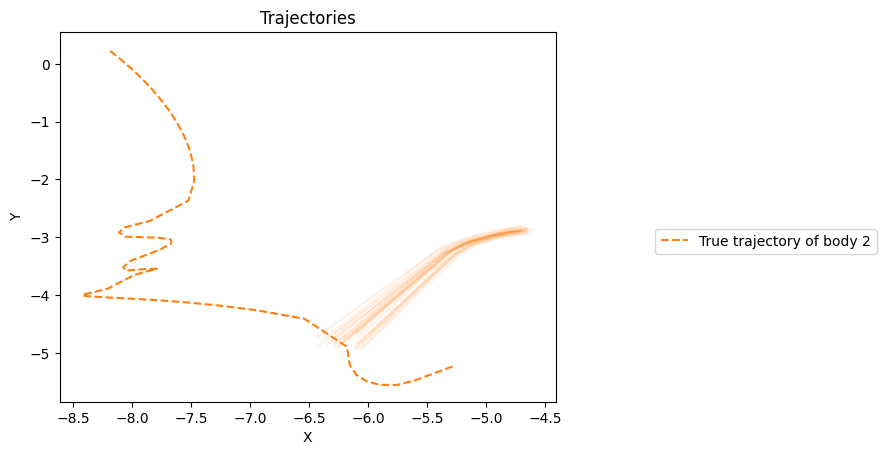

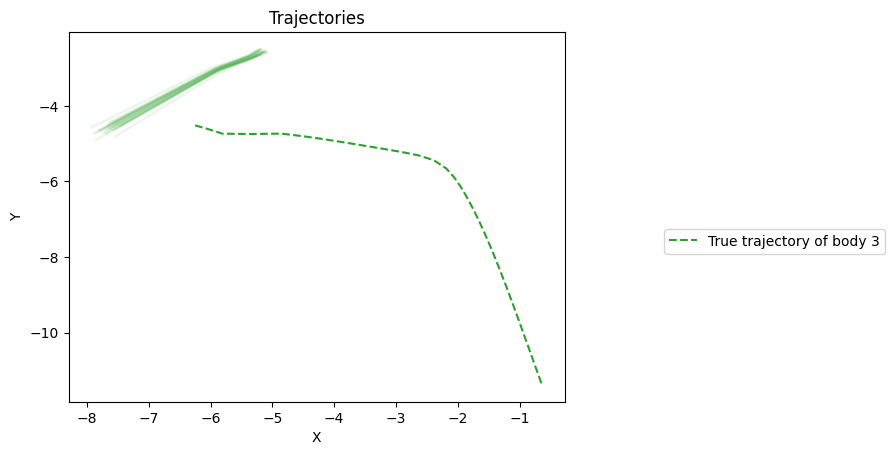

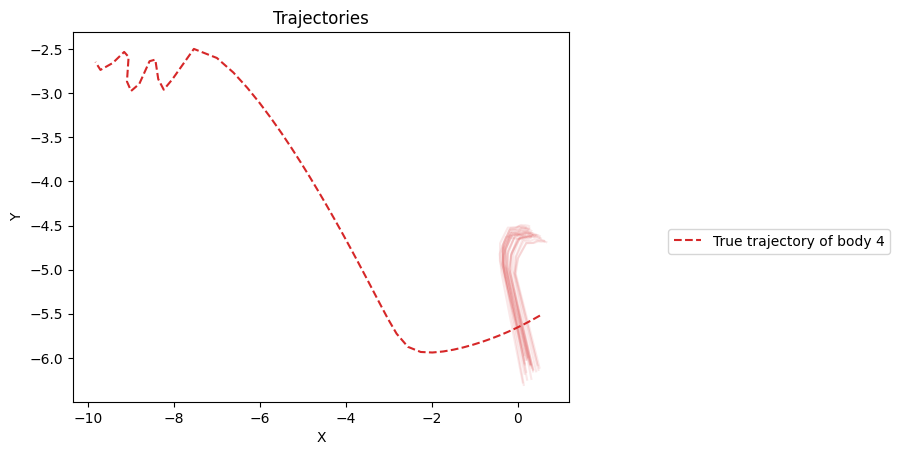

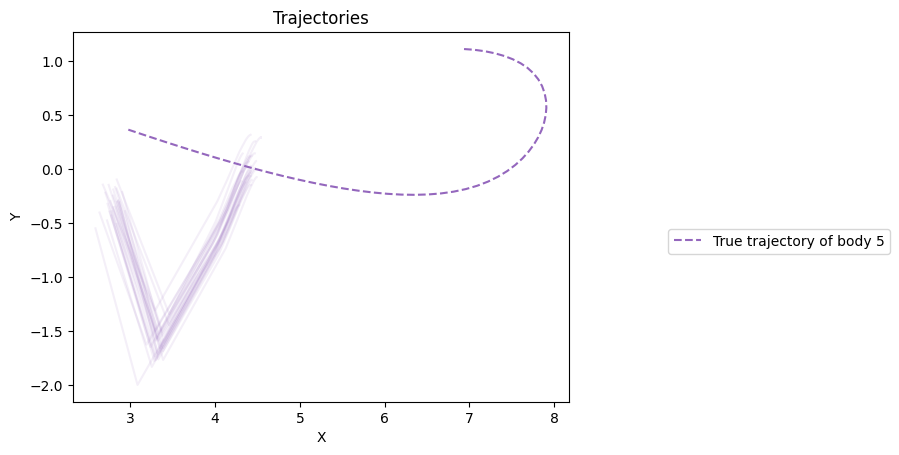

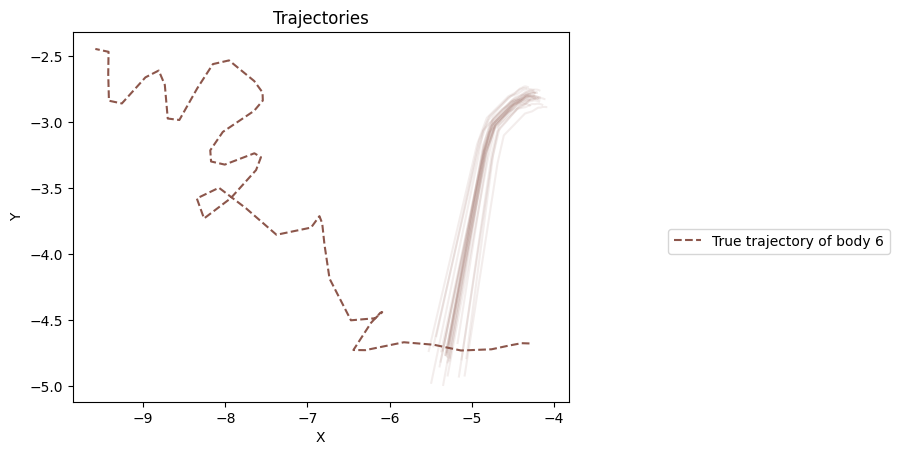

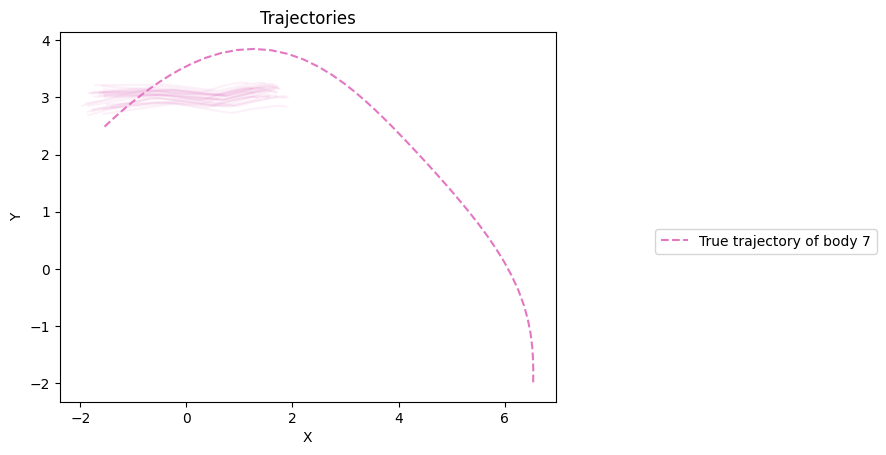

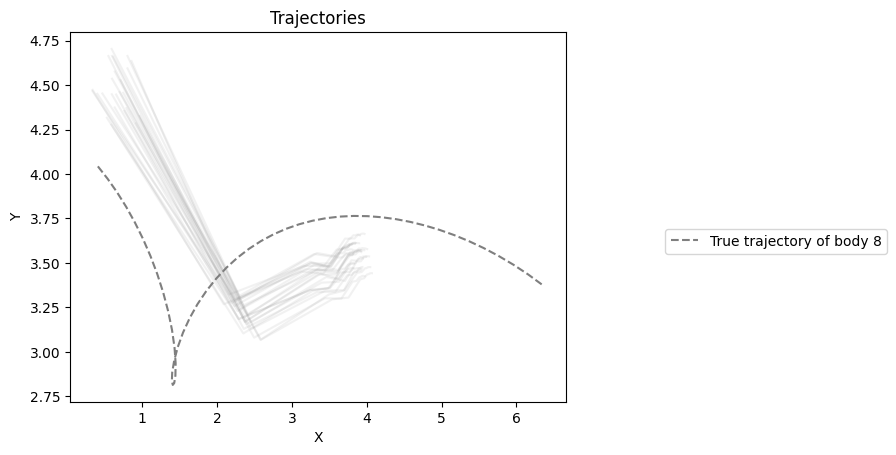

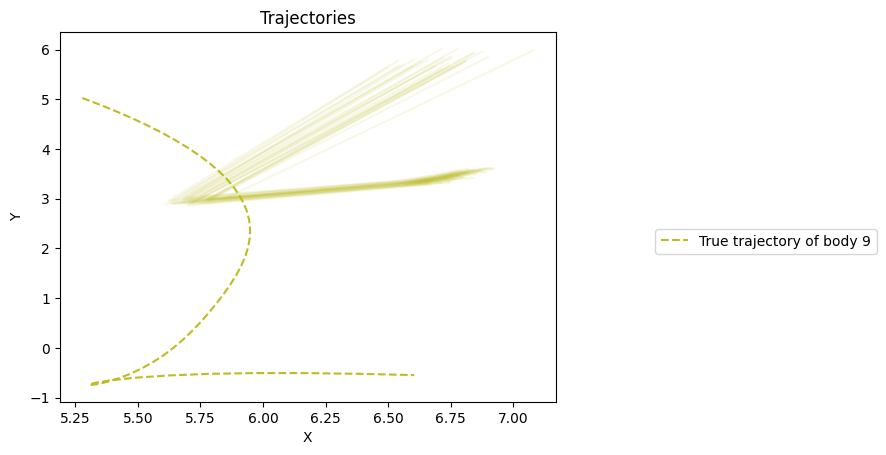

In [183]:
for body_idx in range(len(true_predictions)):
    true_x = true_predictions[body_idx][:,0]
    true_y = true_predictions[body_idx][:,1]
    plt.plot(true_x, true_y, 'b--', color=colors[body_idx], label='True trajectory of body '+str(body_idx+1))
    #print(body_idx)
    for i in range(len(final)):
        pred_x = final[i][body_idx][:,0].detach().numpy()
        #print(pred_x)
        pred_y = final[i][body_idx][:,1].detach().numpy()
        plt.plot(pred_x, pred_y, color=colors[body_idx], alpha=0.1)

    plt.title("Trajectories")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc=(1.2 , 0.4))
    plt.show()